In [255]:
import os
import cv2
import time
import cmapy
import numpy as np
import pandas as pd
from PIL import Image
from scipy import ndimage
import matplotlib.pyplot as plt

In [256]:
base_dir = "../random_test_imgs/ir_test_3/"
ir_dir = os.path.join(base_dir, "ir")
csv_dir = os.path.join(base_dir, "csv")

ir_img_list = [os.path.join(ir_dir, i) for i in os.listdir(ir_dir) if i.endswith(".png")]
csv_img_list = [os.path.join(csv_dir, i) for i in os.listdir(csv_dir) if i.endswith(".csv")]

print("Ensure that the image path matches your system directory structure:")
print(ir_img_list[0])
print(csv_img_list[0])

Ensure that the image path matches your system directory structure:
../random_test_imgs/ir_test_3/ir/ir_3.png
../random_test_imgs/ir_test_3/csv/ir_3.csv


In [257]:
def _temps_to_rescaled_uints(raw_np_image):
    """Function to convert temperatures to pixels on image"""
    # Fix dead pixel
    raw_np_image[6][0] = int((raw_np_image[6][1] + raw_np_image[5][0] + raw_np_image[7][0]) / 3)

    # Just in case there are any NaNs
    raw_np_image = np.nan_to_num(raw_np_image)

    _temp_min = np.min(raw_np_image)
    _temp_max = np.max(raw_np_image)
    norm = np.uint8((raw_np_image - _temp_min)*255/(_temp_max-_temp_min))

    
    norm.shape = (24,32)
    return norm, _temp_min, _temp_max

In [258]:
def _process_raw_image(_raw_image, _interpolation_list, _interpolation_index, _colormap_list, _colormap_index, filter_image=False):
    """Process the raw temp data to a colored image. Filter if necessary"""
    # Image processing
    # Can't apply colormap before ndimage, so reversed in first two options, even though it seems slower
    if _interpolation_index==5:  # Scale via scipy only - slowest but seems higher quality
        _image = ndimage.zoom(_raw_image,25)  # interpolate with scipy
        _image = cv2.applyColorMap(_image, cmapy.cmap(_colormap_list[_colormap_index]))
    elif _interpolation_index==6:  # Scale partially via scipy and partially via cv2 - mix of speed and quality
        _image = ndimage.zoom(_raw_image,10)  # interpolate with scipy
        _image = cv2.applyColorMap(_image, cmapy.cmap(_colormap_list[_colormap_index]))
        _image = cv2.resize(_image, (800,600), interpolation=cv2.INTER_CUBIC)
    else:
        _image = cv2.applyColorMap(_raw_image, cmapy.cmap(_colormap_list[_colormap_index]))
        _image = cv2.resize(_image, (800,600), interpolation=_interpolation_list[_interpolation_index])
    _image = cv2.flip(_image, 1)
    if filter_image:
        _image=cv2.bilateralFilter(_image,15,80,80)
    return _image

In [259]:
def _c_to_f(temp:float):
    """ Convert temperature from C to F """
    return ((9.0/5.0)*temp+32.0)

def _add_image_text(use_f, _image, _temp_min, _temp_max, _interpolation_list_name, _interpolation_index, _colormap_list, _colormap_index, filter_image):
    """Set image text content"""
    if use_f:
        temp_min=_c_to_f(_temp_min)
        temp_max=_c_to_f(_temp_max)
        text = f'Tmin={temp_min:+.1f}F - Tmax={temp_max:+.1f}F - Interpolation: {_interpolation_list_name[_interpolation_index]} - Colormap: {_colormap_list[_colormap_index]} - Filtered: {filter_image}'
    else:
        text = f'Tmin={_temp_min:+.1f}C - Tmax={_temp_max:+.1f}C - Interpolation: {_interpolation_list_name[_interpolation_index]} - Colormap: {_colormap_list[_colormap_index]} - Filtered: {filter_image}'
    cv2.putText(_image, text, (30, 18), cv2.FONT_HERSHEY_SIMPLEX, .4, (255, 255, 255), 1)
    return _image


In [260]:
_colormap_list = ['jet','bwr','seismic','coolwarm','PiYG_r','tab10','tab20','gnuplot2','brg']
_interpolation_list = [cv2.INTER_NEAREST,cv2.INTER_LINEAR,cv2.INTER_AREA,cv2.INTER_CUBIC,cv2.INTER_LANCZOS4,5,6]
_interpolation_list_name = ['Nearest','Inter Linear','Inter Area','Inter Cubic','Inter Lanczos4','Pure Scipy', 'Scipy/CV2 Mixed']
_interpolation_index = 1
_colormap_index = 0

# processed_image = _process_raw_image(rescaled_image, _interpolation_list, _interpolation_index, _colormap_list, _colormap_index, filter_image=False)
# processed_image = _add_image_text(use_f=False, _image=processed_image, _temp_min=_temp_min, _temp_max=_temp_max, _interpolation_list_name=_interpolation_list_name, _interpolation_index=_interpolation_index, _colormap_list=_colormap_list, _colormap_index=_colormap_index, filter_image=False)
# plt.imshow(processed_image)

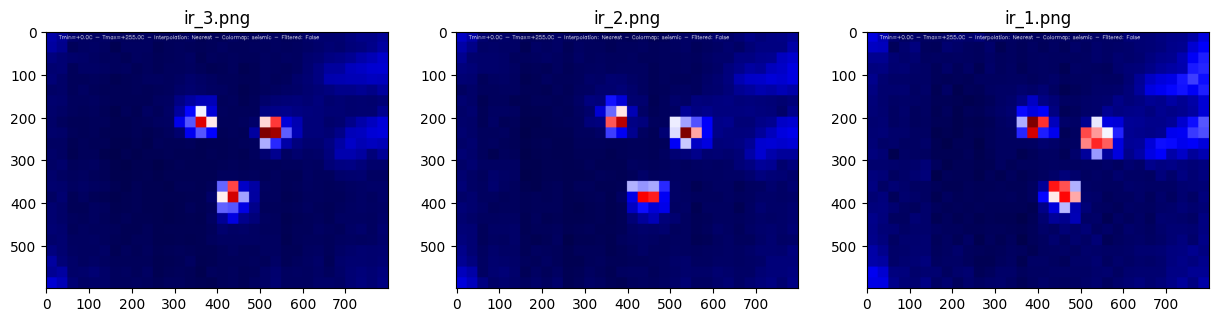

In [281]:
# Apply the above steps to visualize the three ir images in our image list in a matplot grid
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    raw_image = Image.open(ir_img_list[i])
    rescaled_image = np.array(raw_image, dtype=np.uint8)
    processed_image = _process_raw_image(rescaled_image, _interpolation_list, _interpolation_index, _colormap_list, _colormap_index, filter_image=False)
    _temp_min = np.min(processed_image)
    _temp_max = np.max(processed_image)
    processed_image = _add_image_text(use_f=False, _image=processed_image, _temp_min=_temp_min, _temp_max=_temp_max, _interpolation_list_name=_interpolation_list_name, _interpolation_index=_interpolation_index, _colormap_list=_colormap_list, _colormap_index=_colormap_index, filter_image=False)
    # print unique pixel locations cuz the image looks kinda the same to naked eye
    processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
    axs[i].imshow(processed_image)
    axs[i].set_title(ir_img_list[i].split('/')[-1])

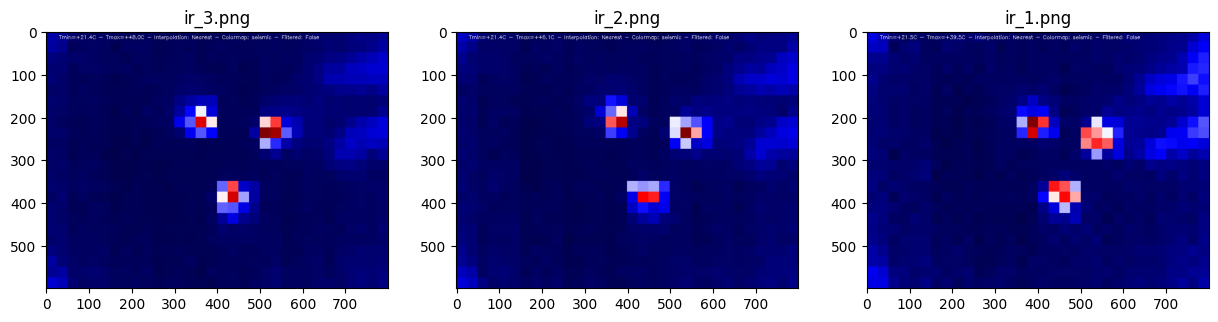

In [280]:
_interpolation_index = 0
_colormap_index = 2

# Apply the above steps to visualize the three ir images in our image list in a matplot grid
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    thermal_df = pd.read_csv(csv_img_list[i], header=None)
    raw_image = thermal_df.to_numpy()
    
    # raw_image[19][3] = int((raw_image[19][2] + raw_image[19][4] + raw_image[18][3] + raw_image[20][3]) / 4)
    rescaled_image, _temp_min, _temp_max = _temps_to_rescaled_uints(raw_image)
    processed_image = _process_raw_image(rescaled_image, _interpolation_list, _interpolation_index, _colormap_list, _colormap_index, filter_image=False)
    processed_image = _add_image_text(use_f=False, _image=processed_image, _temp_min=_temp_min, _temp_max=_temp_max, _interpolation_list_name=_interpolation_list_name, _interpolation_index=_interpolation_index, _colormap_list=_colormap_list, _colormap_index=_colormap_index, filter_image=False)
    # print(np.unique(thermal_np, return_index=True))
    processed_image = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)
    axs[i].imshow(processed_image)
    axs[i].set_title(ir_img_list[i].split('/')[-1])